# Normalizing Flows

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import load_data

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
from zotbin.group import plotfbins
from zotbin.flow import learn_flow

In [4]:
bands='riz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [24]:
undetected = np.any(train_data == 30, axis=1)
print(f'Removing {np.count_nonzero(undetected)} galaxies with undetected flux in at least one band.')
train_data = train_data[~undetected]

Removing 50677 galaxies with undetected flux in at least one band.


Use r-i, z-i, i as the features:

In [25]:
X = np.concatenate((np.diff(train_data, axis=1), train_data[:, 1:2]), axis=1)

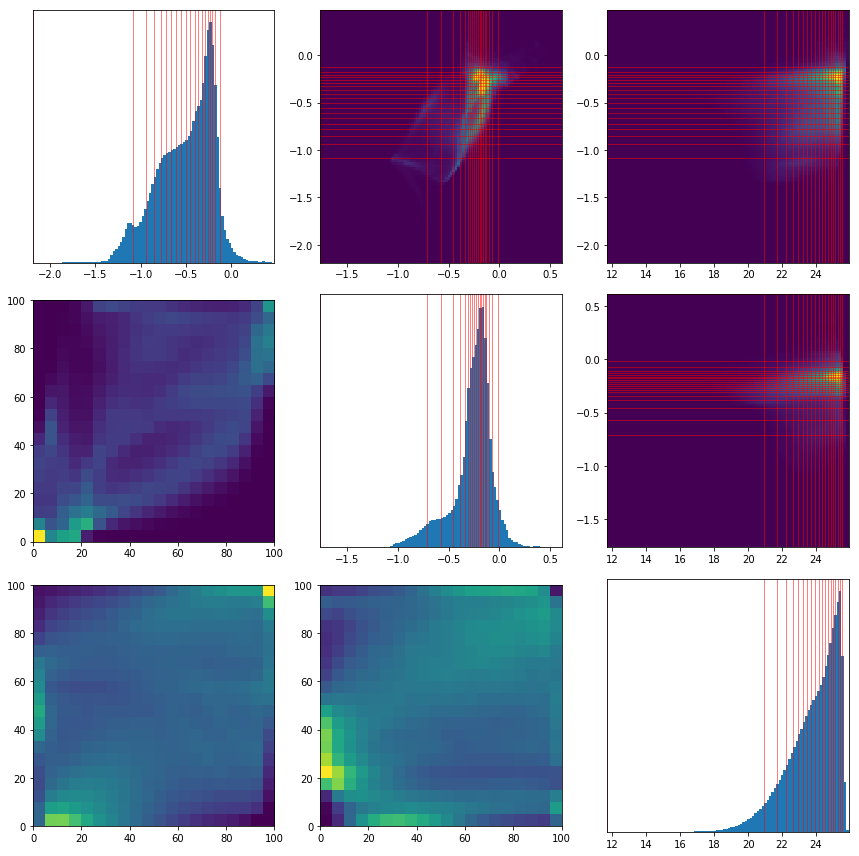

In [26]:
plotfbins(X, inset_pct=0)

epoch 10 loss 2.437


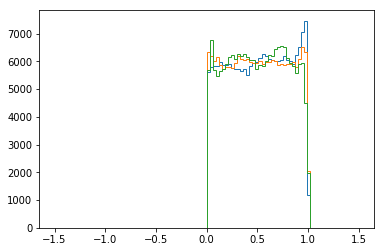

epoch 20 loss 2.382


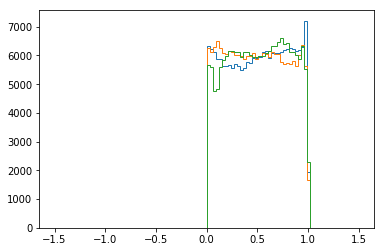

epoch 30 loss 2.466


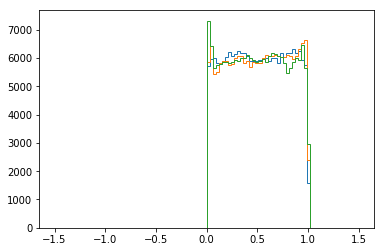

epoch 40 loss 2.402


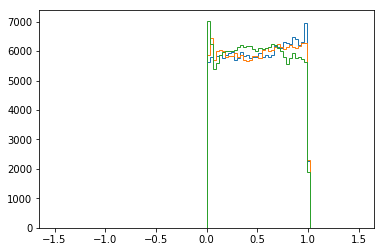

epoch 50 loss 2.445


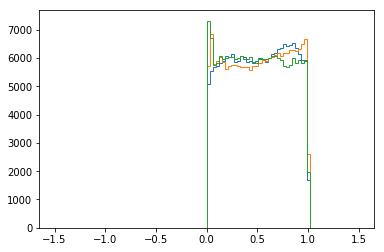

epoch 60 loss 2.347


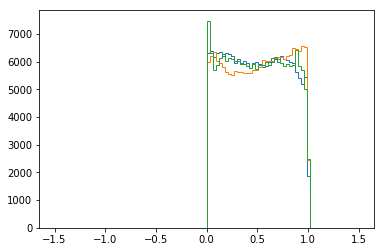

epoch 70 loss 2.350


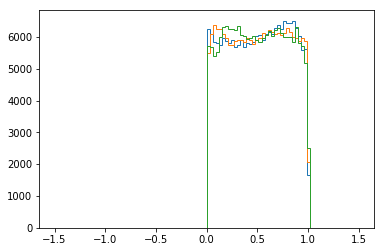

epoch 80 loss 2.377


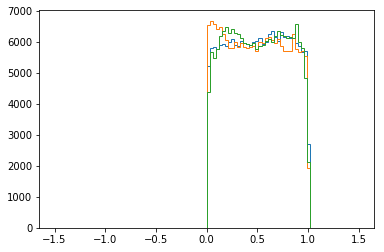

epoch 90 loss 2.363


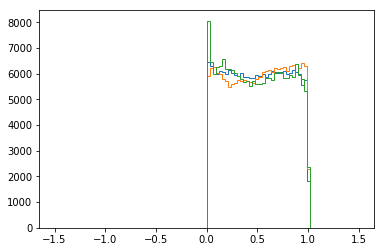

epoch 100 loss 2.348


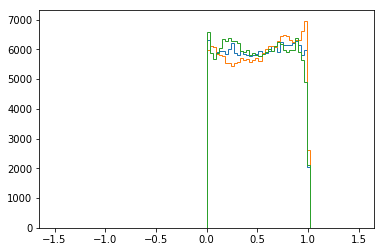

CPU times: user 1min 6s, sys: 3.01 s, total: 1min 9s
Wall time: 36.3 s


In [9]:
%time flow_map = learn_flow(X[:200000], interval=10)

In [10]:
U = flow_map(X)

In [17]:
import scipy.special

In [19]:
U2 = 0.5 * (1 + scipy.special.erf(np.array(U, np.float64) / np.sqrt(2)))

In [20]:
np.all(np.isfinite(U2))

True

In [12]:
X.shape, U.shape

((5410171, 3), (5410171, 3))

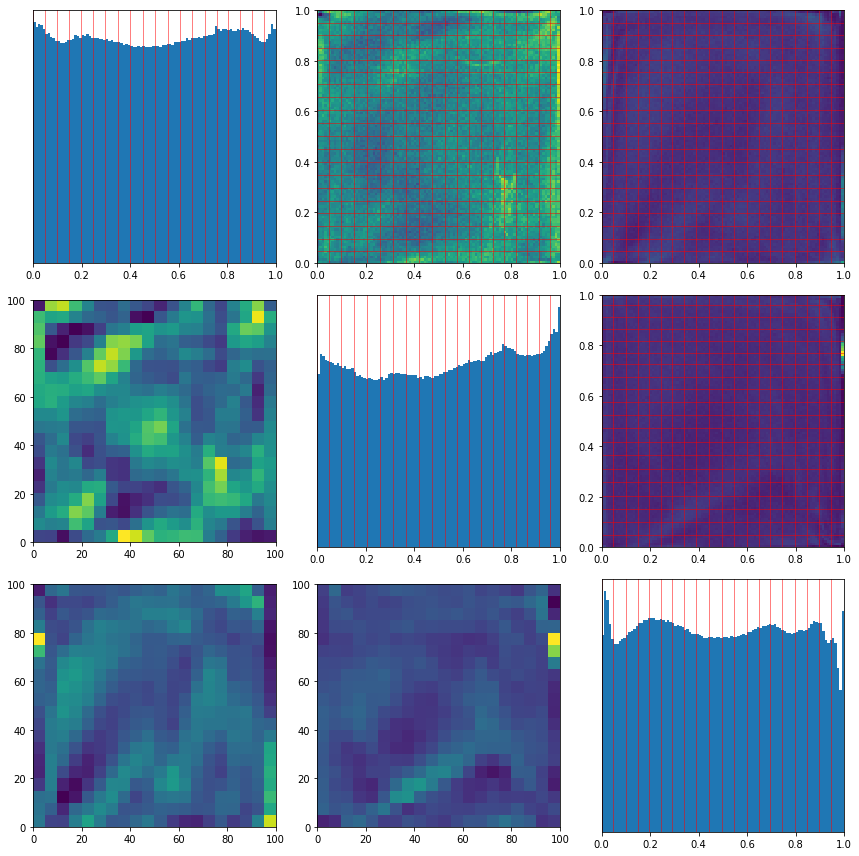

In [22]:
plotfbins(U2, inset_pct=0)

In [12]:
if False:
    n_samples = 10000
    plot_range = [(-2, 2), (-2, 2)]
    n_bins = 100

    scaler = preprocessing.StandardScaler()
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = scaler.fit_transform(X)
    plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1];

In [38]:
rng, flow_rng = jax.random.split(jax.random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 200, 2000

In [39]:
def get_masks(input_dim, hidden_dim, num_hidden):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]
    #print('degrees:', [d.shape for d in degrees])

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    #print('masks:', [m.shape for m in masks])
    return masks

hidden_dim = 48 # 64
num_hidden = 2  # 1
nunit = 5       # 5

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=hidden_dim, num_hidden=num_hidden)
    act = stax.Relu
    stack = [flows.MaskedDense(masks[0]), act]
    for i in range(num_hidden):
        stack += [flows.MaskedDense(masks[i + 1]), act]
    stack.append(flows.MaskedDense(masks[-1].tile(2)))
    init_fun, apply_fun = stax.serial(*stack)
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

# Initialize our flow bijection.
bijection_init_fun = flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * nunit)

# Create direct and inverse bijection functions.
bijection_rng, rng = jax.random.split(rng)
bijection_params, bijection_direct, bijection_inverse = bijection_init_fun(bijection_rng, input_dim)

# Initialize our flow model.
prior_init_fun = flows.Normal()
#prior_init_fun = Uniform()
flow_init_fun = flows.Flow(bijection_init_fun, prior_init_fun)
initial_params, log_pdf, sample = flow_init_fun(flow_rng, input_dim)

degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]


In [50]:
def loss_fn(params, inputs):
    return -log_pdf(params, inputs).mean()

@jax.jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    loss_value, gradients = jax.value_and_grad(loss_fn)(params, inputs)
    return opt_update(i, gradients, opt_state), loss_value

In [55]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3) #1e-4

In [56]:
import jax.scipy.special

In [57]:
import scipy.special

epoch 0 loss 2.9308276176452637
epoch 1
float64


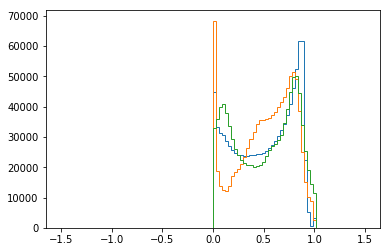

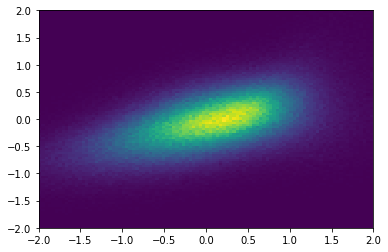

epoch 1 loss 2.7275187969207764
epoch 2 loss 2.5161592960357666
epoch 3 loss 2.465268135070801
epoch 4 loss 2.477200984954834
epoch 5 loss 2.4171323776245117
epoch 6 loss 2.3910436630249023
epoch 7 loss 2.376857042312622
epoch 8 loss 2.3581440448760986
epoch 9 loss 2.329719066619873
epoch 10 loss 2.3588898181915283
epoch 11
float64


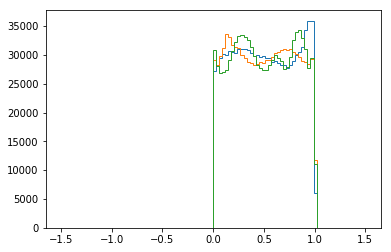

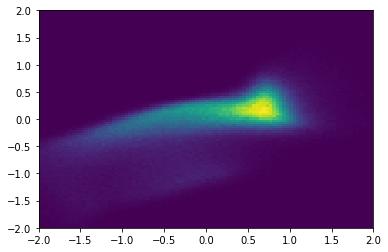

epoch 11 loss 2.4250025749206543
epoch 12 loss 2.3829288482666016
epoch 13 loss 2.4038329124450684
epoch 14 loss 2.335691452026367
epoch 15 loss 2.3232738971710205
epoch 16 loss 2.3625621795654297
epoch 17 loss 2.320849657058716
epoch 18 loss 2.3575098514556885
epoch 19 loss 2.3641085624694824
epoch 20 loss 2.3494882583618164
epoch 21
float64


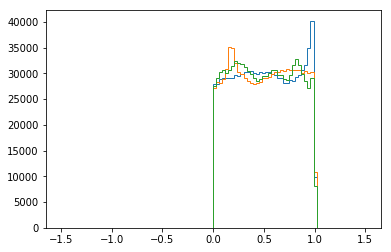

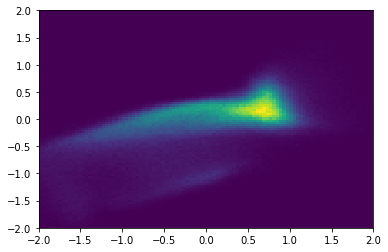

epoch 21 loss 2.3135411739349365
epoch 22 loss 2.3447022438049316
epoch 23 loss 2.3615310192108154
epoch 24 loss 2.370487689971924
epoch 25 loss 2.3806955814361572
epoch 26 loss 2.3363349437713623
epoch 27 loss 2.391342878341675
epoch 28 loss 2.3455820083618164
epoch 29 loss 2.3022427558898926
epoch 30 loss 2.3370938301086426
epoch 31
float64


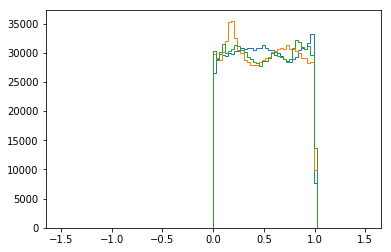

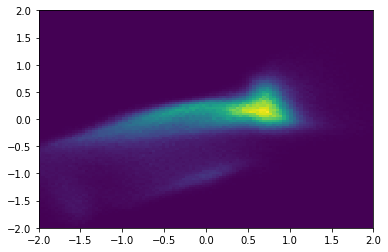

epoch 31 loss 2.337672233581543
epoch 32 loss 2.2924015522003174
epoch 33 loss 2.313624620437622
epoch 34 loss 2.327097177505493
epoch 35 loss 2.2871289253234863
epoch 36 loss 2.3308351039886475
epoch 37 loss 2.2801105976104736
epoch 38 loss 2.310809850692749
epoch 39 loss 2.3020107746124268
epoch 40 loss 2.334261894226074
epoch 41
float64


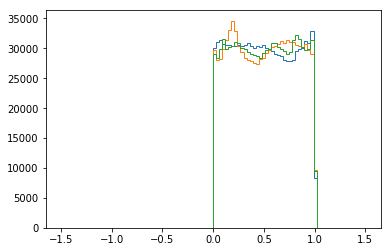

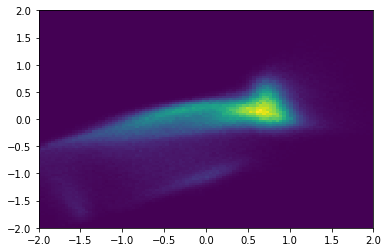

epoch 41 loss 2.2844269275665283
epoch 42 loss 2.3013916015625
epoch 43 loss 2.333775520324707
epoch 44 loss 2.37834095954895
epoch 45 loss 2.5216190814971924
epoch 46 loss 2.390713930130005
epoch 47 loss 2.34989857673645
epoch 48 loss 2.3050479888916016
epoch 49 loss 2.3017287254333496
epoch 50 loss 2.3763086795806885
epoch 51
float64


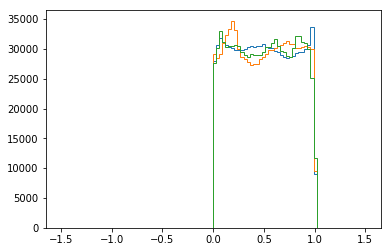

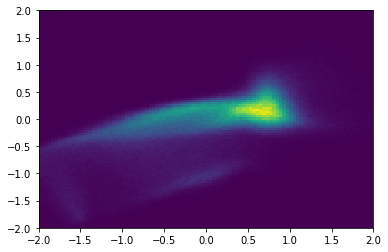

epoch 51 loss 2.3365354537963867
epoch 52 loss 2.3187899589538574
epoch 53 loss 2.279402732849121
epoch 54 loss 2.394343376159668
epoch 55 loss 2.3528270721435547
epoch 56 loss 2.3564577102661133
epoch 57 loss 2.3181183338165283
epoch 58 loss 2.3403160572052
epoch 59 loss 2.3427178859710693
epoch 60 loss 2.324965715408325
epoch 61
float64


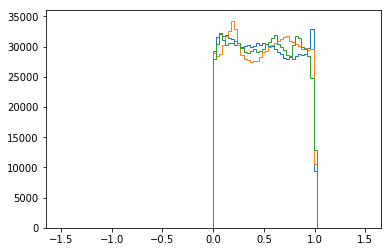

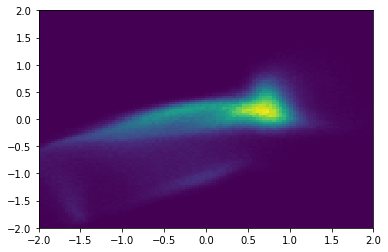

epoch 61 loss 2.2779428958892822
epoch 62 loss 2.282494306564331
epoch 63 loss 2.3516130447387695
epoch 64 loss 2.279709577560425
epoch 65 loss 2.38103985786438
epoch 66 loss 2.3401947021484375
epoch 67 loss 2.3570358753204346
epoch 68 loss 2.371791124343872
epoch 69 loss 2.4111452102661133
epoch 70 loss 2.316934585571289
epoch 71
float64


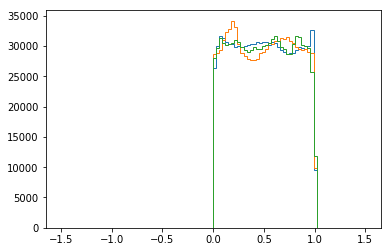

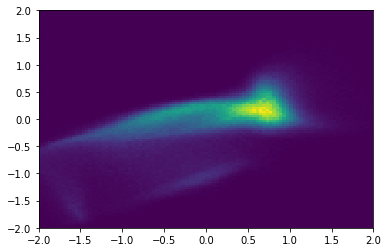

epoch 71 loss 2.3316597938537598
epoch 72 loss 2.3322694301605225
epoch 73 loss 2.379643678665161
epoch 74 loss 2.3209242820739746
epoch 75 loss 2.303722381591797
epoch 76 loss 2.3247272968292236
epoch 77 loss 2.344261884689331
epoch 78 loss 2.311748743057251
epoch 79 loss 2.3277387619018555
epoch 80 loss 2.3936972618103027
epoch 81
float64


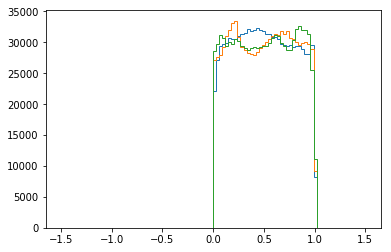

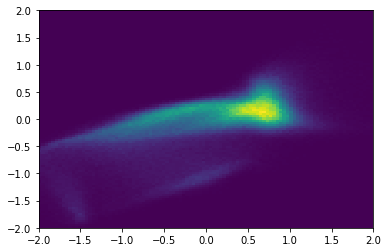

epoch 81 loss 2.2978250980377197
epoch 82 loss 2.3541903495788574
epoch 83 loss 2.284336805343628
epoch 84 loss 2.33602237701416
epoch 85 loss 2.3135011196136475
epoch 86 loss 2.3486430644989014
epoch 87 loss 2.3165385723114014
epoch 88 loss 2.3801467418670654
epoch 89 loss 2.3405277729034424
epoch 90 loss 2.327244281768799
epoch 91
float64


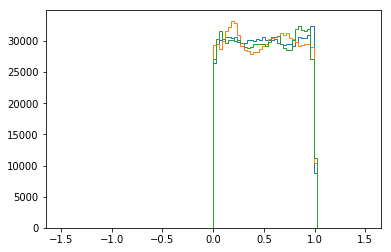

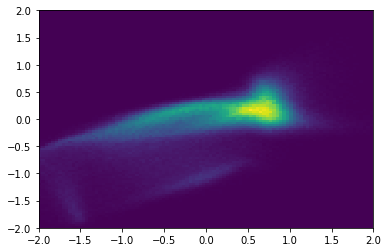

epoch 91 loss 2.2985801696777344
epoch 92 loss 2.3783750534057617
epoch 93 loss 2.3528945446014404
epoch 94 loss 2.3117311000823975
epoch 95 loss 2.3243916034698486
epoch 96 loss 2.3142647743225098
epoch 97 loss 2.3334126472473145
epoch 98 loss 2.3025095462799072
epoch 99 loss 2.3324341773986816
epoch 100 loss 2.3200478553771973
epoch 101
float64


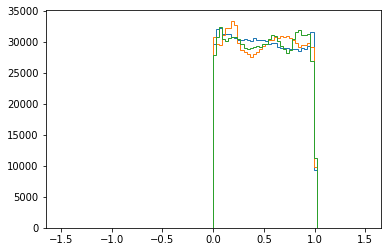

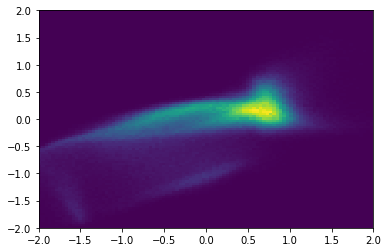

epoch 101 loss 2.279811143875122
epoch 102 loss 2.305907964706421
epoch 103 loss 2.361055850982666
epoch 104 loss 2.3289473056793213
epoch 105 loss 2.3149025440216064
epoch 106 loss 2.301973819732666
epoch 107 loss 2.3294425010681152
epoch 108 loss 2.308581829071045
epoch 109 loss 2.297004222869873
epoch 110 loss 2.320648193359375
epoch 111
float64


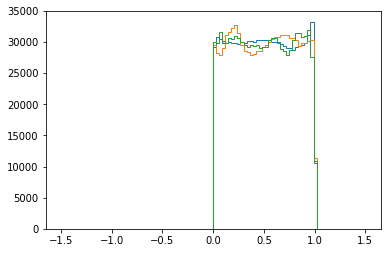

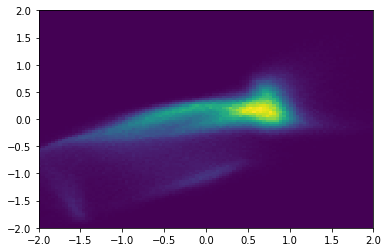

epoch 111 loss 2.3034422397613525
epoch 112 loss 2.3356528282165527
epoch 113 loss 2.3196163177490234
epoch 114 loss 2.2995991706848145
epoch 115 loss 2.328526496887207
epoch 116 loss 2.30252742767334
epoch 117 loss 2.31443452835083
epoch 118 loss 2.271188497543335
epoch 119 loss 2.2998082637786865
epoch 120 loss 2.318673610687256
epoch 121
float64


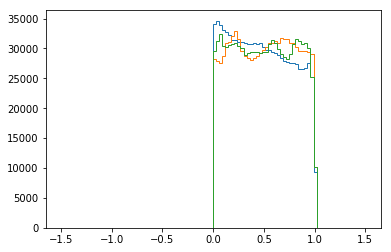

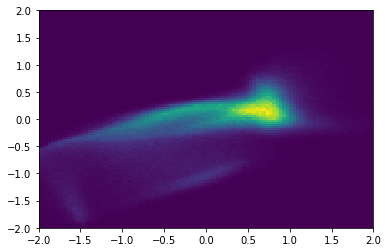

epoch 121 loss 2.256080150604248
epoch 122 loss 2.301403522491455
epoch 123 loss 2.261747121810913
epoch 124 loss 2.269660234451294
epoch 125 loss 2.339609384536743
epoch 126 loss 2.313971519470215
epoch 127 loss 2.300921678543091
epoch 128 loss 2.3270153999328613
epoch 129 loss 2.3505184650421143
epoch 130 loss 2.3153066635131836
epoch 131
float64


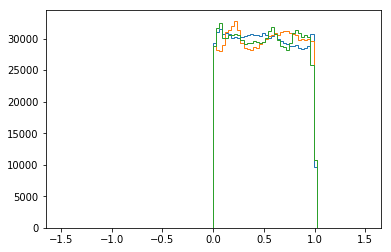

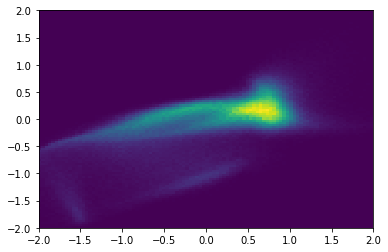

epoch 131 loss 2.2834346294403076
epoch 132 loss 2.313534736633301
epoch 133 loss 2.2703254222869873
epoch 134 loss 2.361896514892578
epoch 135 loss 2.374887228012085
epoch 136 loss 2.269522190093994
epoch 137 loss 2.2768847942352295
epoch 138 loss 2.3076858520507812
epoch 139 loss 2.289401054382324
epoch 140 loss 2.2815985679626465
epoch 141
float64


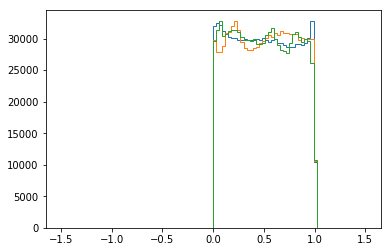

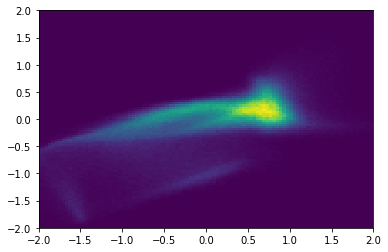

epoch 141 loss 2.2764317989349365
epoch 142 loss 2.29152512550354
epoch 143 loss 2.287841558456421
epoch 144 loss 2.3165526390075684
epoch 145 loss 2.2998790740966797
epoch 146 loss 2.2990212440490723
epoch 147 loss 2.3079946041107178
epoch 148 loss 2.301576852798462
epoch 149 loss 2.262308359146118
epoch 150 loss 2.291637420654297
epoch 151
float64


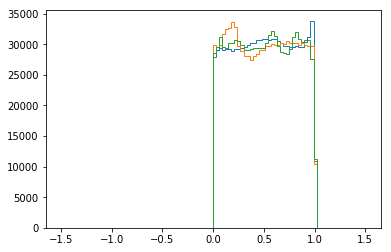

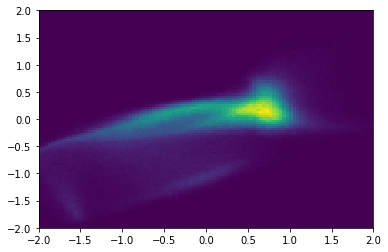

epoch 151 loss 2.243450403213501
epoch 152 loss 2.349980592727661
epoch 153 loss 2.287611961364746
epoch 154 loss 2.2852137088775635
epoch 155 loss 2.339770555496216
epoch 156 loss 2.3001999855041504
epoch 157 loss 2.3294663429260254
epoch 158 loss 2.4022860527038574
epoch 159 loss 2.3104605674743652
epoch 160 loss 2.3301339149475098
epoch 161
float64


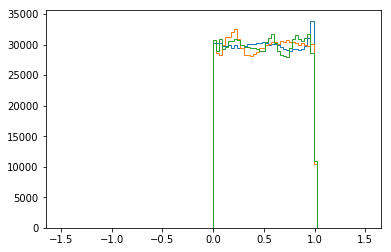

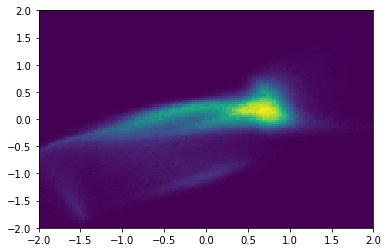

epoch 161 loss 2.300201416015625
epoch 162 loss 2.2697641849517822
epoch 163 loss 2.300628662109375
epoch 164 loss 2.3059184551239014
epoch 165 loss 2.4087259769439697
epoch 166 loss 2.287268877029419
epoch 167 loss 2.3039944171905518
epoch 168 loss 2.293396234512329
epoch 169 loss 2.2952992916107178
epoch 170 loss 2.2919437885284424
epoch 171
float64


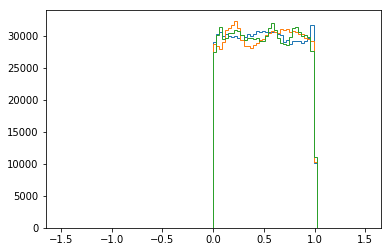

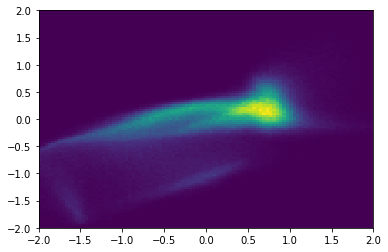

epoch 171 loss 2.334667205810547
epoch 172 loss 2.2979815006256104
epoch 173 loss 2.2667694091796875
epoch 174 loss 2.284970760345459
epoch 175 loss 2.317110538482666
epoch 176 loss 2.2901182174682617
epoch 177 loss 2.345897674560547
epoch 178 loss 2.2839980125427246
epoch 179 loss 2.289761543273926
epoch 180 loss 2.2935454845428467
epoch 181
float64


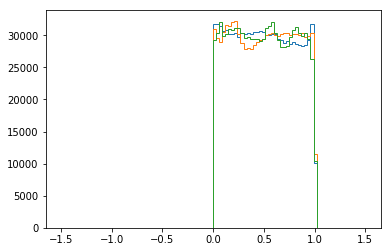

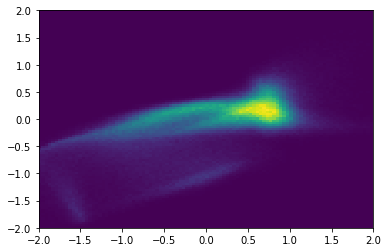

epoch 181 loss 2.283316135406494
epoch 182 loss 2.286149740219116
epoch 183 loss 2.2837038040161133
epoch 184 loss 2.2963309288024902
epoch 185 loss 2.3066842555999756
epoch 186 loss 2.318676471710205
epoch 187 loss 2.2465157508850098
epoch 188 loss 2.300078868865967
epoch 189 loss 2.3667404651641846
epoch 190 loss 2.2922489643096924
epoch 191
float64


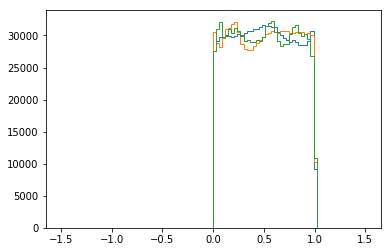

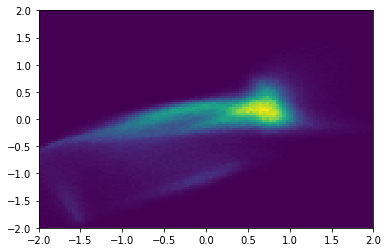

epoch 191 loss 2.219801425933838
epoch 192 loss 2.3612194061279297
epoch 193 loss 2.2427191734313965
epoch 194 loss 2.3025949001312256
epoch 195 loss 2.317223310470581
epoch 196 loss 2.2787675857543945
epoch 197 loss 2.2983267307281494
epoch 198 loss 2.2475268840789795
epoch 199 loss 2.2987892627716064
epoch 200
float64


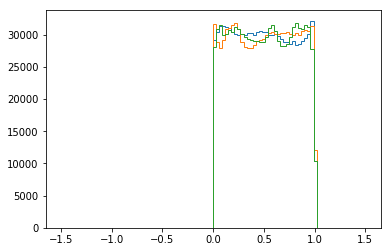

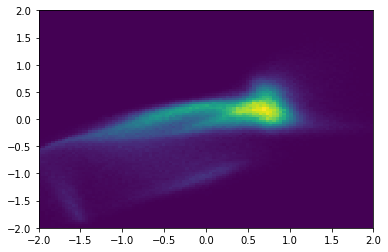

In [59]:
nsample = X.shape[0]
X_trace_in = X.copy()
#bins = np.linspace(-3, 3, 101)
bins = np.linspace(-1.5, 1.5, 101)
bins2d = np.linspace(-2, 2, 101)

opt_state = opt_init(initial_params)
itercount = itertools.count()

for epoch in range(num_epochs):

    permute_rng, rng = jax.random.split(rng)
    X = jax.random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state, loss = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
        
    print(f'epoch {epoch} loss {loss}')
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print('epoch', epoch + 1)
        epoch_params = get_params(opt_state)
        
        # Map the input data back through the flow to the prior space.
        X_trace_out, log_det_jac_inv = bijection_direct(epoch_params, X_trace_in)
        #U = 0.5 * (1 + jax.scipy.special.erf(X_trace_out / jnp.sqrt(2)))
        X_trace_out = np.array(X_trace_out, np.float64)
        U = 0.5 * (1 + scipy.special.erf(X_trace_out / np.sqrt(2)))
        print(U.dtype)
        good = np.isfinite(U)
        if np.any(~good):
            print(f'U has {np.count_nonzero(~good)} bad elements.')
        for i in range(input_dim):
            x = U[:, i]
            plt.hist(x[np.isfinite(x)], bins, histtype='step')
        plt.show()

        # Draw random samples from the prior and pass them through the flow.
        sample_rng, rng = jax.random.split(rng)
        X_syn = sample(rng, epoch_params, nsample)
        plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=bins2d)
        plt.show()